# Vehicle Detection and Tracking

## Step1: Import all packages

In [315]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label
import pickle


In [316]:
### parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720]  # Min and max in y to search in slide_window()

In [317]:
# read training data
#glob.iglob('src/**/*.c', recursive=True)
cars = glob.glob('./training_images/vehicles/**/*.png')
notcars = glob.glob('./training_images/non-vehicles/**/*.png')
print(len(cars))
print(len(notcars))

8792
8968


In [318]:
# extract training features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('train set size:', len(X_train))
print('test set size:', len(X_test))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
train set size: 14208
test set size: 3552


In [319]:
# training
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

48.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9789


In [32]:
# save the params
data = {
    'svc': svc,
    'X_scaler': X_scaler
}
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [160]:
# restore params
dist_pickle = pickle.load( open("data.pickle", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]

231
2


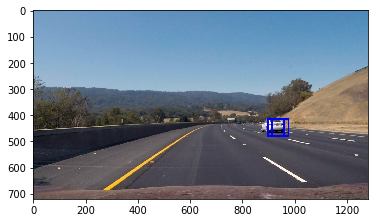

In [339]:
# detect
y_start_stop = [400, 500]  # Min and max in y to search in slide_window()
image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)

image = image.astype('float32')/255

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

print(len(windows))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
print(len(hot_windows))
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


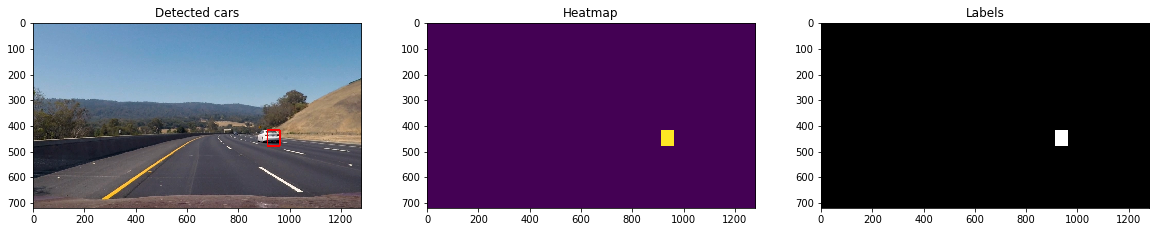

In [341]:
draw_image = np.copy(image)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
add_heat(heat, hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
    
draw_labeled_bboxes(draw_image, labels)
#plt.imshow(draw_image)
#plt.show()

figure, (detected_car_image_plot, detected_car_heatmap_plot, detected_car_labales_plot) = plt.subplots(1, 3, figsize=(20,15))
        
detected_car_image_plot.set_title('Detected cars')
detected_car_image_plot.imshow(draw_image)

detected_car_heatmap_plot.set_title('Heatmap')
detected_car_heatmap_plot.imshow(heatmap)

detected_car_labales_plot.set_title('Labels')
detected_car_labales_plot.imshow(labels[0], cmap='gray')
plt.show()


In [393]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255.0
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = img_tosearch
    #ctrans_tosearch = img
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    #print(nxsteps)
    #print(nysteps)
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            test_prediction = svc.predict(test_features)
            #test_decision = svc.decision_function(test_features)
            
            if test_prediction == 1:
            #if test_decision > 0.7:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    #draw_labeled_bboxes(draw_img, labels)
    
    return hot_windows

In [401]:
history_heat = []
MAX_HISTORY = 10
#history_heat = []

In [402]:
def pipeline(img):
    hot_windows1 = []
    hot_windows2 = []
    hot_windows3 = []
    hot_windows4 = []

    hot_windows1 = find_cars(img, 400, 500, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #hot_windows2 = find_cars(img, 380, 530, 1.1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_windows2 = find_cars(img, 450, 530, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_windows3 = find_cars(img, 380, 530, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #hot_windows1 = find_cars(img, 380, 530, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #plt.imshow(out_img)
    #plt.show()
    #hot_windows2 = find_cars(img, 380, 550, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #plt.imshow(out_img)
    #plt.show()
    #hot_windows3 = find_cars(img, 380, 530, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #plt.imshow(out_img)
    #plt.show()
    #out_img,hot_windows1 = find_cars(img, 380, 530, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #plt.imshow(out_img)
    #plt.show()
    #out_img,hot_windows1 = find_cars(img, 380, 530, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #plt.imshow(out_img)
    #plt.show()
    draw_img = np.copy(img)

    hwin = hot_windows1 + hot_windows2 + hot_windows3
    #hwin = hot_windows1


    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    add_heat(heat, hwin)
    heat = apply_threshold(heat, 1)

    
    if len(history_heat) < MAX_HISTORY:
        history_heat.append(heat)
    else:
        del history_heat[0]
        history_heat.append(heat)
        

    total_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for h in history_heat:
        total_heat += h
    #total_heat += (history_heat[len(history_heat)-1]*2)
    # Apply threshold to help remove false positives

    heat_sum = apply_threshold(total_heat, 16)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_sum, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_labeled_bboxes(draw_img, labels)
    
    #plt.imshow(heat_sum, cmap='hot')
    #plt.show()


    return draw_img

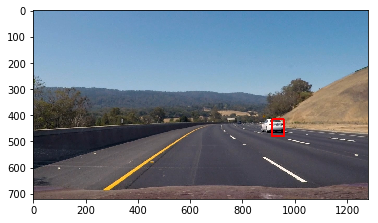

In [363]:
img = mpimg.imread('./test_images/test3.jpg')
out_img = pipeline(img)
plt.imshow(out_img)
plt.show()

In [403]:
from moviepy.editor import VideoFileClip
def detectVideo(input_video,output):
    clip1 = VideoFileClip(input_video)
    out_clip = clip1.fl_image(pipeline)
    out_clip.write_videofile(output,audio=False)

#detectVideo('test_video.mp4','test_video_output.mp4')
#project_video.mp4
detectVideo('project_video.mp4','project_video_out.mp4')


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<28:35,  1.36s/it]

  0%|          | 2/1261 [00:02<28:28,  1.36s/it]

  0%|          | 3/1261 [00:04<28:16,  1.35s/it]

  0%|          | 4/1261 [00:05<28:07,  1.34s/it]

  0%|          | 5/1261 [00:06<28:10,  1.35s/it]

  0%|          | 6/1261 [00:08<28:04,  1.34s/it]

  1%|          | 7/1261 [00:09<28:01,  1.34s/it]

  1%|          | 8/1261 [00:10<28:03,  1.34s/it]

  1%|          | 9/1261 [00:12<28:02,  1.34s/it]

  1%|          | 10/1261 [00:13<28:02,  1.34s/it]

  1%|          | 11/1261 [00:14<27:59,  1.34s/it]

  1%|          | 12/1261 [00:16<27:56,  1.34s/it]

  1%|          | 13/1261 [00:17<27:54,  1.34s/it]

  1%|          | 14/1261 [00:18<27:52,  1.34s/it]

  1%|          | 15/1261 [00:20<27:54,  1.34s/it]

  1%|▏         | 16/1261 [00:21<27:58,  1.35s/it]

  1%|▏         | 17/1261 [00:22<27:54,  1.35s/it]

  1%|▏         | 18/1261 [00:24<27:47,  1.34s/it]

  2%|▏         | 19/1261 [00:25<27:41,  1.34s/i

 11%|█▏        | 143/1261 [03:12<25:03,  1.34s/it]

 11%|█▏        | 144/1261 [03:13<25:02,  1.35s/it]

 11%|█▏        | 145/1261 [03:15<25:03,  1.35s/it]

 12%|█▏        | 146/1261 [03:16<25:00,  1.35s/it]

 12%|█▏        | 147/1261 [03:17<24:57,  1.34s/it]

 12%|█▏        | 148/1261 [03:19<24:56,  1.34s/it]

 12%|█▏        | 149/1261 [03:20<24:55,  1.35s/it]

 12%|█▏        | 150/1261 [03:22<24:49,  1.34s/it]

 12%|█▏        | 151/1261 [03:23<25:03,  1.35s/it]

 12%|█▏        | 152/1261 [03:24<24:57,  1.35s/it]

 12%|█▏        | 153/1261 [03:26<24:49,  1.34s/it]

 12%|█▏        | 154/1261 [03:27<24:43,  1.34s/it]

 12%|█▏        | 155/1261 [03:28<24:39,  1.34s/it]

 12%|█▏        | 156/1261 [03:30<24:39,  1.34s/it]

 12%|█▏        | 157/1261 [03:31<24:36,  1.34s/it]

 13%|█▎        | 158/1261 [03:32<24:37,  1.34s/it]

 13%|█▎        | 159/1261 [03:34<24:35,  1.34s/it]

 13%|█▎        | 160/1261 [03:35<24:31,  1.34s/it]

 13%|█▎        | 161/1261 [03:36<24:27,  1.33s/it]

 13%|█▎     

 23%|██▎       | 284/1261 [06:23<21:51,  1.34s/it]

 23%|██▎       | 285/1261 [06:24<21:50,  1.34s/it]

 23%|██▎       | 286/1261 [06:26<21:54,  1.35s/it]

 23%|██▎       | 287/1261 [06:27<21:54,  1.35s/it]

 23%|██▎       | 288/1261 [06:28<21:51,  1.35s/it]

 23%|██▎       | 289/1261 [06:30<22:03,  1.36s/it]

 23%|██▎       | 290/1261 [06:31<21:59,  1.36s/it]

 23%|██▎       | 291/1261 [06:32<21:55,  1.36s/it]

 23%|██▎       | 292/1261 [06:34<21:54,  1.36s/it]

 23%|██▎       | 293/1261 [06:35<22:04,  1.37s/it]

 23%|██▎       | 294/1261 [06:37<21:58,  1.36s/it]

 23%|██▎       | 295/1261 [06:38<22:07,  1.37s/it]

 23%|██▎       | 296/1261 [06:39<21:58,  1.37s/it]

 24%|██▎       | 297/1261 [06:41<22:17,  1.39s/it]

 24%|██▎       | 298/1261 [06:42<22:20,  1.39s/it]

 24%|██▎       | 299/1261 [06:44<22:20,  1.39s/it]

 24%|██▍       | 300/1261 [06:45<22:05,  1.38s/it]

 24%|██▍       | 301/1261 [06:46<21:58,  1.37s/it]

 24%|██▍       | 302/1261 [06:48<21:50,  1.37s/it]

 24%|██▍    

 34%|███▎      | 425/1261 [09:35<18:46,  1.35s/it]

 34%|███▍      | 426/1261 [09:36<18:53,  1.36s/it]

 34%|███▍      | 427/1261 [09:37<18:49,  1.35s/it]

 34%|███▍      | 428/1261 [09:39<18:44,  1.35s/it]

 34%|███▍      | 429/1261 [09:40<18:44,  1.35s/it]

 34%|███▍      | 430/1261 [09:41<18:40,  1.35s/it]

 34%|███▍      | 431/1261 [09:43<18:37,  1.35s/it]

 34%|███▍      | 432/1261 [09:44<18:36,  1.35s/it]

 34%|███▍      | 433/1261 [09:45<18:44,  1.36s/it]

 34%|███▍      | 434/1261 [09:47<18:49,  1.37s/it]

 34%|███▍      | 435/1261 [09:48<18:53,  1.37s/it]

 35%|███▍      | 436/1261 [09:50<18:45,  1.36s/it]

 35%|███▍      | 437/1261 [09:51<18:38,  1.36s/it]

 35%|███▍      | 438/1261 [09:52<18:32,  1.35s/it]

 35%|███▍      | 439/1261 [09:54<18:29,  1.35s/it]

 35%|███▍      | 440/1261 [09:55<18:26,  1.35s/it]

 35%|███▍      | 441/1261 [09:56<18:23,  1.35s/it]

 35%|███▌      | 442/1261 [09:58<18:21,  1.34s/it]

 35%|███▌      | 443/1261 [09:59<18:30,  1.36s/it]

 35%|███▌   

 45%|████▍     | 566/1261 [12:46<15:47,  1.36s/it]

 45%|████▍     | 567/1261 [12:47<15:49,  1.37s/it]

 45%|████▌     | 568/1261 [12:48<15:45,  1.36s/it]

 45%|████▌     | 569/1261 [12:50<15:42,  1.36s/it]

 45%|████▌     | 570/1261 [12:51<15:53,  1.38s/it]

 45%|████▌     | 571/1261 [12:53<15:43,  1.37s/it]

 45%|████▌     | 572/1261 [12:54<15:39,  1.36s/it]

 45%|████▌     | 573/1261 [12:55<15:35,  1.36s/it]

 46%|████▌     | 574/1261 [12:57<15:33,  1.36s/it]

 46%|████▌     | 575/1261 [12:58<15:28,  1.35s/it]

 46%|████▌     | 576/1261 [12:59<15:36,  1.37s/it]

 46%|████▌     | 577/1261 [13:01<15:30,  1.36s/it]

 46%|████▌     | 578/1261 [13:02<15:26,  1.36s/it]

 46%|████▌     | 579/1261 [13:03<15:23,  1.35s/it]

 46%|████▌     | 580/1261 [13:05<15:20,  1.35s/it]

 46%|████▌     | 581/1261 [13:06<15:26,  1.36s/it]

 46%|████▌     | 582/1261 [13:07<15:22,  1.36s/it]

 46%|████▌     | 583/1261 [13:09<15:18,  1.35s/it]

 46%|████▋     | 584/1261 [13:10<15:13,  1.35s/it]

 46%|████▋  

 56%|█████▌    | 707/1261 [15:57<12:33,  1.36s/it]

 56%|█████▌    | 708/1261 [15:58<12:29,  1.36s/it]

 56%|█████▌    | 709/1261 [15:59<12:27,  1.35s/it]

 56%|█████▋    | 710/1261 [16:01<12:24,  1.35s/it]

 56%|█████▋    | 711/1261 [16:02<12:24,  1.35s/it]

 56%|█████▋    | 712/1261 [16:04<12:29,  1.37s/it]

 57%|█████▋    | 713/1261 [16:05<12:29,  1.37s/it]

 57%|█████▋    | 714/1261 [16:06<12:25,  1.36s/it]

 57%|█████▋    | 715/1261 [16:08<12:22,  1.36s/it]

 57%|█████▋    | 716/1261 [16:09<12:19,  1.36s/it]

 57%|█████▋    | 717/1261 [16:10<12:15,  1.35s/it]

 57%|█████▋    | 718/1261 [16:12<12:13,  1.35s/it]

 57%|█████▋    | 719/1261 [16:13<12:11,  1.35s/it]

 57%|█████▋    | 720/1261 [16:14<12:09,  1.35s/it]

 57%|█████▋    | 721/1261 [16:16<12:08,  1.35s/it]

 57%|█████▋    | 722/1261 [16:17<12:05,  1.35s/it]

 57%|█████▋    | 723/1261 [16:18<12:12,  1.36s/it]

 57%|█████▋    | 724/1261 [16:20<12:11,  1.36s/it]

 57%|█████▋    | 725/1261 [16:21<12:06,  1.36s/it]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [19:08<09:13,  1.34s/it]

 67%|██████▋   | 849/1261 [19:09<09:12,  1.34s/it]

 67%|██████▋   | 850/1261 [19:11<09:12,  1.34s/it]

 67%|██████▋   | 851/1261 [19:12<09:10,  1.34s/it]

 68%|██████▊   | 852/1261 [19:13<09:09,  1.34s/it]

 68%|██████▊   | 853/1261 [19:15<09:07,  1.34s/it]

 68%|██████▊   | 854/1261 [19:16<09:14,  1.36s/it]

 68%|██████▊   | 855/1261 [19:17<09:10,  1.36s/it]

 68%|██████▊   | 856/1261 [19:19<09:13,  1.37s/it]

 68%|██████▊   | 857/1261 [19:20<09:09,  1.36s/it]

 68%|██████▊   | 858/1261 [19:22<09:13,  1.37s/it]

 68%|██████▊   | 859/1261 [19:23<09:08,  1.36s/it]

 68%|██████▊   | 860/1261 [19:24<09:05,  1.36s/it]

 68%|██████▊   | 861/1261 [19:26<09:09,  1.37s/it]

 68%|██████▊   | 862/1261 [19:27<09:04,  1.36s/it]

 68%|██████▊   | 863/1261 [19:28<09:04,  1.37s/it]

 69%|██████▊   | 864/1261 [19:30<09:01,  1.36s/it]

 69%|██████▊   | 865/1261 [19:31<08:57,  1.36s/it]

 69%|██████▊   | 866/1261 [19:32<08:54,  1.35s/it]

 69%|██████▉

 78%|███████▊  | 989/1261 [22:19<06:10,  1.36s/it]

 79%|███████▊  | 990/1261 [22:21<06:08,  1.36s/it]

 79%|███████▊  | 991/1261 [22:22<06:10,  1.37s/it]

 79%|███████▊  | 992/1261 [22:24<06:10,  1.38s/it]

 79%|███████▊  | 993/1261 [22:25<06:06,  1.37s/it]

 79%|███████▉  | 994/1261 [22:26<06:04,  1.36s/it]

 79%|███████▉  | 995/1261 [22:28<06:01,  1.36s/it]

 79%|███████▉  | 996/1261 [22:29<05:59,  1.36s/it]

 79%|███████▉  | 997/1261 [22:30<05:58,  1.36s/it]

 79%|███████▉  | 998/1261 [22:32<05:57,  1.36s/it]

 79%|███████▉  | 999/1261 [22:33<05:56,  1.36s/it]

 79%|███████▉  | 1000/1261 [22:34<05:55,  1.36s/it]

 79%|███████▉  | 1001/1261 [22:36<05:53,  1.36s/it]

 79%|███████▉  | 1002/1261 [22:37<05:52,  1.36s/it]

 80%|███████▉  | 1003/1261 [22:38<05:51,  1.36s/it]

 80%|███████▉  | 1004/1261 [22:40<05:49,  1.36s/it]

 80%|███████▉  | 1005/1261 [22:41<05:52,  1.38s/it]

 80%|███████▉  | 1006/1261 [22:43<05:49,  1.37s/it]

 80%|███████▉  | 1007/1261 [22:44<05:46,  1.37s/it]

 80%

 89%|████████▉ | 1128/1261 [25:28<03:01,  1.36s/it]

 90%|████████▉ | 1129/1261 [25:30<02:59,  1.36s/it]

 90%|████████▉ | 1130/1261 [25:31<02:58,  1.36s/it]

 90%|████████▉ | 1131/1261 [25:32<02:56,  1.36s/it]

 90%|████████▉ | 1132/1261 [25:34<02:55,  1.36s/it]

 90%|████████▉ | 1133/1261 [25:35<02:53,  1.36s/it]

 90%|████████▉ | 1134/1261 [25:37<02:52,  1.36s/it]

 90%|█████████ | 1135/1261 [25:38<02:51,  1.36s/it]

 90%|█████████ | 1136/1261 [25:39<02:49,  1.36s/it]

 90%|█████████ | 1137/1261 [25:41<02:49,  1.37s/it]

 90%|█████████ | 1138/1261 [25:42<02:48,  1.37s/it]

 90%|█████████ | 1139/1261 [25:43<02:46,  1.36s/it]

 90%|█████████ | 1140/1261 [25:45<02:44,  1.36s/it]

 90%|█████████ | 1141/1261 [25:46<02:44,  1.37s/it]

 91%|█████████ | 1142/1261 [25:47<02:42,  1.37s/it]

 91%|█████████ | 1143/1261 [25:49<02:40,  1.36s/it]

 91%|█████████ | 1144/1261 [25:50<02:39,  1.36s/it]

 91%|█████████ | 1145/1261 [25:52<02:38,  1.37s/it]

 91%|█████████ | 1146/1261 [25:53<02:36,  1.36

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [400]:
def clipVideo(input_video,output,start,end):
    clip1 = VideoFileClip(input_video)
    clip1 = clip1.subclip(start,end)
    out_clip = clip1.fl_image(pipeline)
    out_clip.write_videofile(output,audio=False)



#clipVideo('test_video.mp4','test_video_clip.mp4',0,1)
clipVideo('project_video.mp4','project_video_clip.mp4',45,46)

[MoviePy] >>>> Building video project_video_clip.mp4
[MoviePy] Writing video project_video_clip.mp4




  0%|          | 0/26 [00:00<?, ?it/s]

  4%|▍         | 1/26 [00:01<00:33,  1.34s/it]

  8%|▊         | 2/26 [00:02<00:32,  1.35s/it]

 12%|█▏        | 3/26 [00:04<00:30,  1.34s/it]

 15%|█▌        | 4/26 [00:05<00:29,  1.34s/it]

 19%|█▉        | 5/26 [00:06<00:28,  1.34s/it]

 23%|██▎       | 6/26 [00:08<00:26,  1.34s/it]

 27%|██▋       | 7/26 [00:09<00:25,  1.35s/it]

 31%|███       | 8/26 [00:10<00:24,  1.34s/it]

 35%|███▍      | 9/26 [00:12<00:22,  1.34s/it]

 38%|███▊      | 10/26 [00:13<00:21,  1.34s/it]

 42%|████▏     | 11/26 [00:14<00:20,  1.34s/it]

 46%|████▌     | 12/26 [00:16<00:18,  1.34s/it]

 50%|█████     | 13/26 [00:17<00:17,  1.34s/it]

 54%|█████▍    | 14/26 [00:18<00:16,  1.34s/it]

 58%|█████▊    | 15/26 [00:20<00:14,  1.34s/it]

 62%|██████▏   | 16/26 [00:21<00:13,  1.33s/it]

 65%|██████▌   | 17/26 [00:22<00:12,  1.33s/it]

 69%|██████▉   | 18/26 [00:24<00:10,  1.33s/it]

 73%|███████▎  | 19/26 [00:25<00:09,  1.33s/it]

 77%|███████▋  | 20/26 [00:26<00:08,

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_clip.mp4 

